## Cats vs Dogs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
import zipfile, shutil
import cv2,h5py
import os, sys, glob
import itertools

from keras import backend
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop, Adam, Adadelta, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger,  History, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input as renet50_process
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_process
from keras.applications.vgg19 import VGG19, preprocess_input as vgg19_process
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_process
from keras.applications.xception import Xception, preprocess_input as xception_process
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet2_process

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from custom_model import vgg_16,resnet_50,xception, inception_v3, inception_resnetv2, fine_tune, get_features, show_loss, fine_tuning
from custom_utils import get_train_data, get_test_data
from visualization import pick_small_size, exp_pic_size

%matplotlib inline



/home/fountainhead_gq/anaconda3/envs/tensorflow_p35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 一、数据预处理

- 查看原训练集图片的大小尺寸和异常的图片，进行图片缩放，移除异常的图片，归一化等等处理操作
- 再读取猫狗图片，并定义训练集图片的标签,猫为0、狗为1
- 再将原训练集划分为训练集和验证集

100%|██████████| 12452/12452 [03:47<00:00, 54.64it/s]


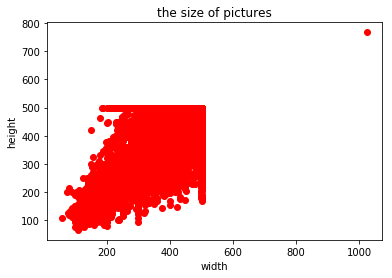

In [2]:
# 查看训练集图片的尺寸
path = os.getcwd()
path_cat = os.path.join(path, r'cat')
exp_pic_size(path_cat)

100%|██████████| 12500/12500 [03:54<00:00, 53.30it/s]


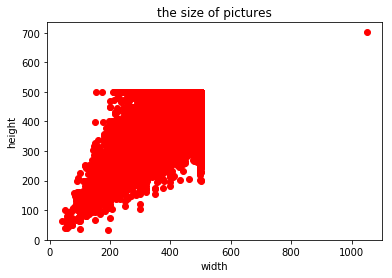

In [3]:
# 查看训练集图片的尺寸
path_dog = os.path.join(path, r'dog')
exp_pic_size(path_dog)

100%|██████████| 12500/12500 [03:59<00:00, 52.10it/s]


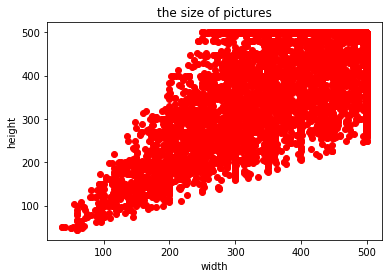

In [4]:
# 查看测试集的尺寸
path_test = os.path.join(path, r'test')
exp_pic_size(path_test)

In [2]:
# path = os.getcwd()
# path_cat = os.path.join(path, r'cat')
# path_dog = os.path.join(path, r'dog')
# path_test = os.path.join(path, r'test')

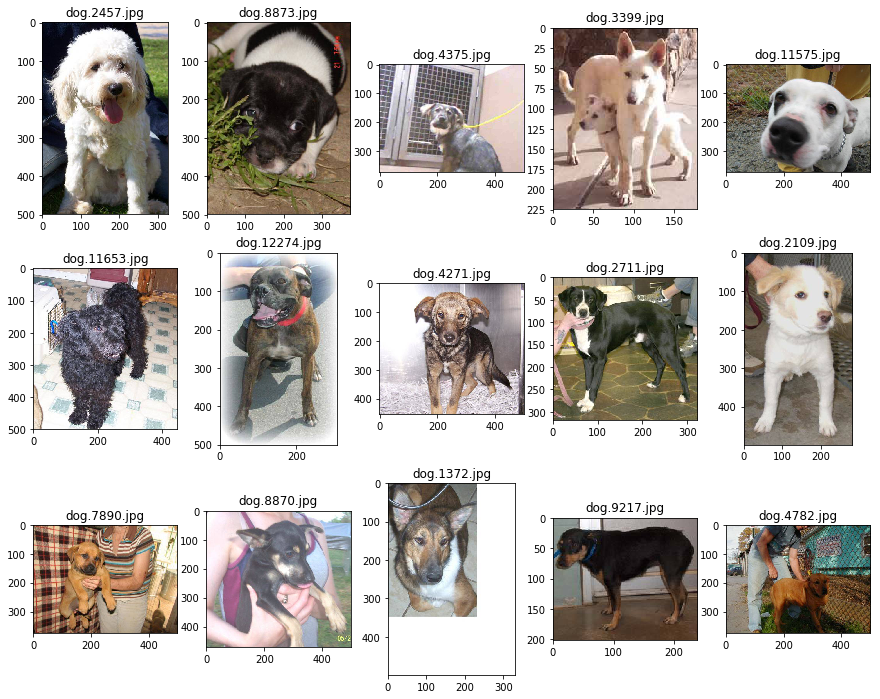

In [3]:
# 可视化查看
plt.figure(figsize=(15, 12))
for i in range(15):
    plt.subplot(3, 5, i+1)
    img = load_img(os.path.join(path_dog, os.listdir(path_dog)[i]) )
    plt.title(os.listdir(path_dog)[i])
    plt.imshow(img)
    #plt.show()

In [11]:
def visualise_image(path_img):
    plt.figure(figsize=(15, 12))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        img = load_img(os.path.join(path_img, os.listdir(path_img)[i]))
        plt.title(os.listdir(path_img)[i])
        plt.imshow(img)    

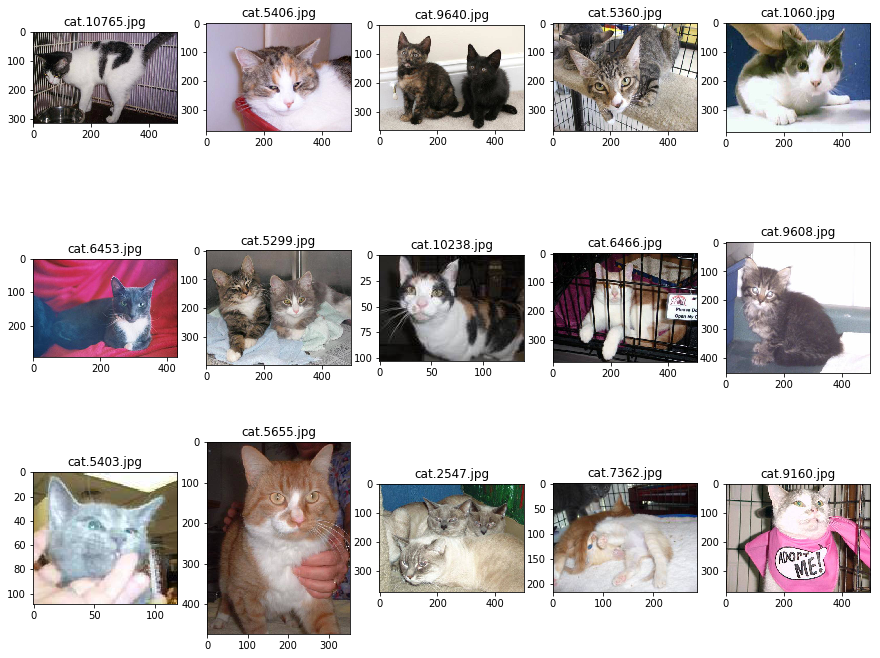

In [12]:
visualise_image(path_cat)

In [3]:
# plt.figure(figsize=(15, 12))
# for i in range(15):
#     plt.subplot(3, 5, i+1)
#     img = load_img(os.path.join(path_cat, os.listdir(path_cat)[i]) )
#     plt.title(os.listdir(path_cat)[i])
#     plt.imshow(img)


#### 检查异常图片，并移除

In [6]:
# low resolution pictures，<100*100
pick_cat = pick_small_size(path_cat)
print(pick_cat)

# for img_name in pic_size:
#     img = load_img(os.path.join(path_cat, img_name))
#     x = img_to_array(img)
#     plt.title(img_name)
#     plt.imshow(img)
#     plt.show()

100%|██████████| 12500/12500 [00:28<00:00, 435.00it/s]

['cat.8585.jpg', 'cat.6614.jpg', 'cat.5534.jpg', 'cat.4833.jpg', 'cat.7314.jpg', 'cat.5257.jpg', 'cat.4670.jpg', 'cat.3739.jpg', 'cat.11094.jpg', 'cat.2433.jpg', 'cat.4963.jpg', 'cat.6402.jpg', 'cat.8470.jpg', 'cat.8087.jpg', 'cat.7487.jpg', 'cat.596.jpg', 'cat.10893.jpg', 'cat.2095.jpg', 'cat.10107.jpg', 'cat.1423.jpg', 'cat.5954.jpg', 'cat.10392.jpg', 'cat.2753.jpg', 'cat.4629.jpg', 'cat.3980.jpg', 'cat.11091.jpg', 'cat.485.jpg', 'cat.3641.jpg', 'cat.5527.jpg', 'cat.8138.jpg', 'cat.8504.jpg', 'cat.4821.jpg', 'cat.7703.jpg', 'cat.10277.jpg']


In [7]:
# low resolution pictures，<100*100
pick_dog = pick_small_size(path_dog)
print(pick_dog)

100%|██████████| 12500/12500 [00:29<00:00, 429.85it/s]

['dog.11686.jpg', 'dog.9456.jpg', 'dog.927.jpg', 'dog.10654.jpg', 'dog.296.jpg', 'dog.9288.jpg', 'dog.5618.jpg', 'dog.7765.jpg', 'dog.7459.jpg', 'dog.7772.jpg', 'dog.630.jpg', 'dog.11248.jpg', 'dog.2652.jpg', 'dog.10385.jpg', 'dog.10664.jpg', 'dog.12185.jpg', 'dog.8570.jpg', 'dog.1174.jpg', 'dog.3147.jpg', 'dog.2068.jpg', 'dog.10155.jpg', 'dog.9705.jpg', 'dog.943.jpg', 'dog.10733.jpg', 'dog.11465.jpg', 'dog.1381.jpg', 'dog.2188.jpg', 'dog.8987.jpg', 'dog.1324.jpg', 'dog.10225.jpg', 'dog.7374.jpg', 'dog.2965.jpg', 'dog.7011.jpg', 'dog.8450.jpg', 'dog.9246.jpg', 'dog.8428.jpg', 'dog.4134.jpg', 'dog.10637.jpg', 'dog.3074.jpg', 'dog.7421.jpg', 'dog.10747.jpg', 'dog.7369.jpg']


In [10]:
# pick out the outliers & low resolution pictures
outlier_cat = ['cat.92.jpg', 'cat.724.jpg', 'cat.1450.jpg', 'cat.3216.jpg', 'cat.3822.jpg', 'cat.5351.jpg','cat.5418.jpg',  'cat.7377.jpg',
 'cat.7564.jpg', 'cat.8456.jpg', 'cat.9171.jpg',  'cat.10029.jpg', 'cat.10712.jpg', 'cat.11184.jpg']
pick_cat.extend(outlier_cat)

In [12]:
# pick out the outliers & low resolution pictures
outlier_dog=  [ 'dog.1259.jpg', 'dog.1835.jpg', 'dog.2614.jpg','dog.3889.jpg', 'dog.4367.jpg', 'dog.5604.jpg', 'dog.8736.jpg', 
               'dog.8898.jpg', 'dog.9517.jpg', 'dog.10161.jpg', 'dog.10190.jpg', 'dog.10237.jpg', 'dog.10401.jpg',
                'dog.10797.jpg', 'dog.10801.jpg', 'dog.11186.jpg', 'dog.11299.jpg', 'dog.12376.jpg','dog.10747.jpg']
pick_dog.extend(outlier_dog)

In [17]:
# 移除不符合要求的图片至文件夹outlier
path_outlier = os.path.join(path, r'outlier')
if not os.path.isdir(path_outlier):
    os.mkdir(path_outlier)

# remove these pictures 
for img_name in pick_cat:
    shutil.move((os.path.join(path_cat, img_name)), (os.path.join(path_outlier, img_name)))

In [19]:
# remove these dogs pictures 
for img_name in pick_dog:
    shutil.move((os.path.join(path_dog, img_name)), (os.path.join(path_outlier, img_name)))
 

#### 读入数据

In [4]:
# 读取训练集
X_train_299, y_train_299 = get_train_data(299)

100%|██████████| 12440/12440 [03:15<00:00, 69.64it/s]


In [5]:
print(X_train_299.shape)
print(y_train_299.shape)

(24892, 299, 299, 3)
(24892,)


In [6]:
# 读取测试集
X_test_299 = get_test_data(299)
print(X_test_299.shape)

100%|██████████| 12500/12500 [00:42<00:00, 293.52it/s]

(12500, 299, 299, 3)


## 二、使用预训练模型（单一）

#### 为了减少模型训练的时间，直接采用keras提供训练好的模型：Xception，InceptionResNetV2，InceptionV3 等。
- 首先使用预训练模型，导入预训练模型(卷积部分)，并锁定模型所有层以避免被训练修改，`layers.trainable = False`。
- 依次设置模型，卷积后进行全局平均池化（GAP）、Dropout和Dense。然后编译模型，优化器为Adadelta。
- 定义回调函数，保存最佳模型，根据val_loss监控训练情况，让模型更好的预测。
- 最后训练模型，预测结果。

### 1. 预训练模型 Xception

In [7]:
# 分成训练集和验证集
X_train_299, X_valid_299, y_train_299, y_valid_299 = train_test_split(X_train_299, y_train_299, test_size=0.2, random_state=42)

In [8]:
model_xception = xception(299)

Xception has 136 layers.


In [9]:
model_xception.fit(X_train_299, y_train_299, batch_size=32, epochs=1, validation_data=(X_valid_299, y_valid_299))

Train on 19913 samples, validate on 4979 samples
Epoch 1/1
19913/19913 [==============================] - 523s 26ms/step - loss: 0.1080 - acc: 0.9738 - val_loss: 0.0650 - val_acc: 0.9823


In [42]:
# 预测提交
y_pred_xception = model_xception.predict(X_test_299)
y_pred_xception = y_pred_xception.clip(min=0.005, max=0.995)
y_pred_xception = y_pred_xception.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': y_pred_xception})
submission.to_csv('xception_submission.csv',index=False)


### CAM 可视化

In [11]:
base_model = Xception(include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_299, y_train_299, batch_size=64, epochs=1, validation_data=(X_valid_299, y_valid_299))

Train on 19913 samples, validate on 4979 samples
Epoch 1/1
19913/19913 [==============================] - 512s 26ms/step - loss: 0.1353 - acc: 0.9674 - val_loss: 6.5287 - val_acc: 0.5214


In [12]:
model_xception = Model(inputs=base_model.input, outputs=[base_model.output, model.output])
weights = model.layers[-1].get_weights()[0]

In [ ]:
import random
img_width, img_height = 299, 299
plt.figure(figsize=(15, 16))
for i in range(1, 16):
    img = cv2.imread(os.path.join(path_test, '%d.jpg'% random.randint(1, X_test_299.shape[0])))
    img = cv2.resize(img,(img_width, img_height))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model_xception.predict(np.expand_dims(x, axis=0))
    prediction = prediction[0]
    out = out[0]    
    plt.subplot(3, 5, i)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (img_width, img_height))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])   

### 2. 预训练模型 InceptionV3

In [9]:
model_inceptionV3 = inception_v3(299)

model_inceptionV3.fit(X_train_299, y_train_299, batch_size=32, epochs=10, validation_data=(X_valid_299, y_valid_299))

model_inceptionV3 has 315 layers.
Train on 19913 samples, validate on 4979 samples
Epoch 1/10
19913/19913 [==============================] - 367s 18ms/step - loss: 0.1759 - acc: 0.9390 - val_loss: 0.1573 - val_acc: 0.9412
Epoch 2/10
19913/19913 [==============================] - 355s 18ms/step - loss: 0.1098 - acc: 0.9593 - val_loss: 0.1565 - val_acc: 0.9420
Epoch 3/10
19913/19913 [==============================] - 355s 18ms/step - loss: 0.0892 - acc: 0.9668 - val_loss: 0.0471 - val_acc: 0.9853
Epoch 4/10
19913/19913 [==============================] - 355s 18ms/step - loss: 0.0873 - acc: 0.9668 - val_loss: 0.1204 - val_acc: 0.9598
Epoch 5/10
19913/19913 [==============================] - 355s 18ms/step - loss: 0.0844 - acc: 0.9676 - val_loss: 0.0612 - val_acc: 0.9799
Epoch 6/10
19913/19913 [==============================] - 355s 18ms/step - loss: 0.0822 - acc: 0.9689 - val_loss: 0.0728 - val_acc: 0.9765
Epoch 7/10
19913/19913 [==============================] - 355s 18ms/step - loss: 0.

In [15]:
def predict_img(MODE, path_test, X_test_num, img_size=None):
    import random
    #img_width, img_height = 299, 299
    if not img_size:
        img_size = (299, 299)
        
    plt.figure(figsize=(15, 12))
    for i in range(1, 21): 
        img = cv2.imread(os.path.join(path_test, '%d.jpg'% random.randint(1, X_test_num)))
        img = cv2.resize(img, img_size)
        x = img.copy()
        x.astype(np.float32)
        prediction = MODE.predict(np.expand_dims(x, axis=0))[0]
        plt.subplot(4, 5, i)
        
        if prediction < 0.5:
            plt.title('cat %.2f%%' % (100 - prediction*100))
        else:
            plt.title('dog %.2f%%' % (prediction*100))
        
        plt.axis('off')
        plt.imshow(x[:,:,::-1]) # convert BGR to RGB

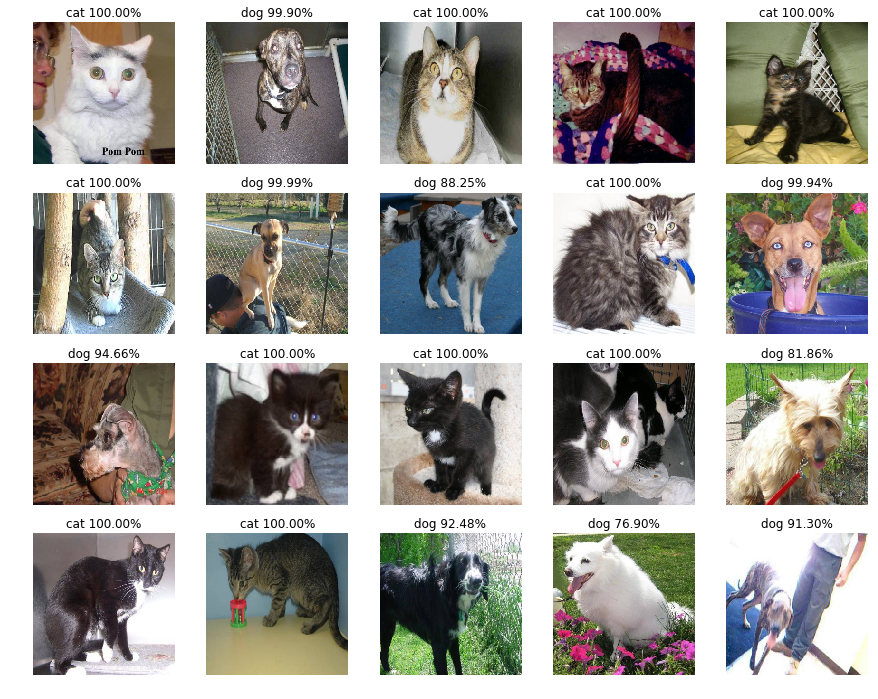

In [16]:
predict_img(model_inceptionV3, path_test, X_test_299.shape[0])

In [49]:
model_inceptionV3.fit(X_train_299, y_train_299, batch_size=32, epochs=4, validation_data=(X_valid_299, y_valid_299))

Train on 19913 samples, validate on 4979 samples
Epoch 1/3
19913/19913 [==============================] - 350s 18ms/step - loss: 0.0837 - acc: 0.9684 - val_loss: 0.0626 - val_acc: 0.9741
Epoch 2/3
19913/19913 [==============================] - 351s 18ms/step - loss: 0.0853 - acc: 0.9697 - val_loss: 0.0584 - val_acc: 0.9781
Epoch 3/3
19913/19913 [==============================] - 349s 18ms/step - loss: 0.0792 - acc: 0.9704 - val_loss: 0.0576 - val_acc: 0.9781


In [43]:
# predict
y_pred_inceptionV3 = model_inceptionV3.predict(X_test_299)
y_pred_inceptionV3 = y_pred_inceptionV3.clip(min=0.005, max=0.995)
y_pred_inceptionV3 = y_pred_inceptionV3.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': y_pred_inceptionV3})
submission.to_csv('inceptionV3_submission.csv',index=False)

### 3. 预训练模型 InceptionResNetV2

In [54]:
model_inceptionResNetV2 = inception_resnetv2(299)

model_inceptionResNetV2.fit(X_train_299, y_train_299, batch_size=32, epochs=10, validation_data=(X_valid_299, y_valid_299))

model_inceptionResNetV2 has 783 layers.
Train on 19913 samples, validate on 4979 samples
Epoch 1/10
19913/19913 [==============================] - 667s 33ms/step - loss: 0.2060 - acc: 0.9469 - val_loss: 0.1047 - val_acc: 0.9789
Epoch 2/10
19913/19913 [==============================] - 661s 33ms/step - loss: 0.1037 - acc: 0.9681 - val_loss: 0.0772 - val_acc: 0.9803
Epoch 3/10
19913/19913 [==============================] - 661s 33ms/step - loss: 0.0851 - acc: 0.9723 - val_loss: 0.0669 - val_acc: 0.9819
Epoch 4/10
19913/19913 [==============================] - 661s 33ms/step - loss: 0.0802 - acc: 0.9721 - val_loss: 0.0620 - val_acc: 0.9823
Epoch 5/10
19913/19913 [==============================] - 661s 33ms/step - loss: 0.0740 - acc: 0.9739 - val_loss: 0.0584 - val_acc: 0.9803
Epoch 6/10
19913/19913 [==============================] - 661s 33ms/step - loss: 0.0727 - acc: 0.9732 - val_loss: 0.0543 - val_acc: 0.9821
Epoch 7/10
19913/19913 [==============================] - 660s 33ms/step - lo

In [56]:
# predict
y_pred_inceptionResNetV2 = model_inceptionResNetV2.predict(X_test_299)
y_pred_inceptionResNetV2 = y_pred_inceptionResNetV2.clip(min=0.005, max=0.995)
y_pred_inceptionResNetV2 = y_pred_inceptionResNetV2.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': y_pred_inceptionResNetV2})
submission.to_csv('inceptionResNetV2_submission.csv',index=False)
# submission.head()

In [ ]:
# show_loss(model_inceptionResNetV2)

## 三、对预训练模型微调


前面的单一模型全部跑完了，随后挑选一个效果比较好的模型，希望通过fine-tune来解冻靠近输出的层，看看能不能进一步的提升表现，通过实验发现通常会有一定的提升。

**fine-tune**的基本思路就是解锁模型比较靠后的层，对模型进行训练；通常解冻的属于同一个组合的层；依次从输出层到输入层的方向解冻，解冻一部分就训练几轮。再观察下loss和accuracy是否改善。反复调试，直到达到满意的结果。


In [27]:
# block14
model_Xception = fine_tuning(model_xception,  X_train_299, y_train_299, X_valid_299, y_valid_299, 299, 125, batch_size=64, epochs=2)

Train on 19913 samples, validate on 4979 samples
Epoch 1/2
19913/19913 [==============================] - 529s 27ms/step - loss: 0.0318 - acc: 0.9889 - val_loss: 0.0539 - val_acc: 0.9851
Epoch 2/2
19913/19913 [==============================] - 528s 27ms/step - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0246 - val_acc: 0.9936


In [33]:
# block13
log_file = 'finetune-125-0.0246.h5'
model_Xception = fine_tuning(model_xception, X_train_299, y_train_299, X_valid_299, y_valid_299, 299, 115, 64, weights=log_file)

Train on 19913 samples, validate on 4979 samples
Epoch 1/3
19913/19913 [==============================] - 573s 29ms/step - loss: 0.0086 - acc: 0.9972 - val_loss: 0.0242 - val_acc: 0.9932
Epoch 2/3
19913/19913 [==============================] - 572s 29ms/step - loss: 0.0053 - acc: 0.9981 - val_loss: 0.0248 - val_acc: 0.9940
Epoch 3/3
19913/19913 [==============================] - 572s 29ms/step - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0299 - val_acc: 0.9942


In [37]:
# block12
log_file = 'finetune-115-0.0242.h5'
model_Xception = fine_tuning(model_xception, X_train_299, y_train_299, X_valid_299, y_valid_299, 299, 105, 64, weights=log_file)

Train on 19913 samples, validate on 4979 samples
Epoch 1/3
19913/19913 [==============================] - 617s 31ms/step - loss: 0.0092 - acc: 0.9971 - val_loss: 0.0257 - val_acc: 0.9948
Epoch 2/3
19913/19913 [==============================] - 616s 31ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0610 - val_acc: 0.9851
Epoch 3/3
19913/19913 [==============================] - 616s 31ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0185 - val_acc: 0.9950


In [ ]:
#block10-11
# log_file = 'finetune-105-0.0185.h5'
# model_Xception = fine_tuning(model_xception, X_train_299, y_train_299, X_valid_299, y_valid_299, 299, 95, 64, weights=log_file)

In [42]:
y_pred_xception = model_Xception.predict(X_test_299)
y_pred_xception = y_pred_xception.clip(min=0.005, max=0.995)
y_pred_xception = y_pred_xception.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': y_pred_xception})
submission.to_csv('ft_xception_submission.csv',index=False)
# submission.head()

## 四、 多个预训练模型融合，提取特征向量

- 融合InceptionV3、Xception、InceptionResNetV2三种模型。
- 计算出每个模型对整个训练集的输出值（去除分类器部分）
- 将多个模型计算得到的特征向量融合，训练分类器

In [5]:
train_InceptionV3, test_InceptionV3 = get_features(InceptionV3, inception_v3_process, 299, X_train_299, X_test_299,train_label=y_train_299)

In [6]:
train_Xception, test_Xception = get_features(Xception, xception_process, 299, X_train_299, X_test_299, train_label=y_train_299)

In [7]:
train_InceptionResNetV2, test_InceptionResNetV2 = get_features(InceptionResNetV2, inception_resnet2_process, 299, 
                                                               X_train_299, X_test_299, train_label=y_train_299)

In [70]:
# fetch_file = ['feature_Xception.h5', 'feature_InceptionV3.h5', 'feature_InceptionResNetV2.h5', 'feature_ResNet50.h5']

train, test= [], []
for fetchfile in ['feature_Xception.h5', 'feature_InceptionV3.h5', 'feature_InceptionResNetV2.h5']:
    with h5py.File(fetchfile, 'r') as h:
        train.append(np.array(h['train']))
        test.append(np.array(h['test']))
        label = np.array(h['label'])

In [71]:
fetch_feature_train = np.concatenate(train, axis=1)
fetch_feature_test = np.concatenate(test, axis=1)

In [74]:
fetch_feature_train.shape,fetch_feature_test.shape

((24892, 5632), (12500, 5632))

In [78]:
X_ft_train, X_ft_valid, y_ft_train, y_ft_valid = train_test_split(fetch_feature_train, y_train_299, test_size=0.2, random_state=42)

In [94]:
X_ft_valid.shape

(4979, 5632)

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_299, y_train_299, batch_size=32, epochs=1, validation_data=(X_valid_299, y_valid_299))

model2 = Model(inputs=base_model.input, outputs=[base_model.output, model.output])
out_base, out_final = model2.predict(np.expand_dims(X_train_299[1], axis=0))

weights = model.layers[-1].get_weights()[0]
print(out_base.shape, out_final.shape, weights.shape)

In [90]:
# inputs = Input(shape=(X_ft_train.shape[1],))
inputs = Input(shape=(img_height, img_width, 3))

input_tensor = Lambda(xception_process)(inputs)
base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
# base_model = Xception(inputs, include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False

x = Dropout(0.25)(base_model.output)    
x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)
fetch_feature_model = Model(inputs=base_model.input, outputs=x)
fetch_feature_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

logs_file = 'ft_extract_features-{val_loss:.4f}.h5'
path = os.getcwd()
path_logs = os.path.join(path, logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
# feature_loss = LossHistory()
model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)
    
fetch_feature_model.fit(X_ft_train, y_ft_train, batch_size=32, epochs=10, 
               validation_data=(X_ft_valid, y_ft_valid))

ValueError: Error when checking input: expected input_12 to have 4 dimensions, but got array with shape (19913, 5632)

In [11]:
inputs = Input(shape=(X_ft_train.shape[1],))
x = Dropout(0.25)(inputs)
x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)
fetch_feature_model = Model(inputs=inputs, outputs=x)
fetch_feature_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

logs_file = 'ft_extract_features-{val_loss:.4f}.h5'
path = os.getcwd()
path_logs = os.path.join(path, logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
# feature_loss = LossHistory()
model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)
    
fetch_feature_model.fit(X_ft_train, y_ft_train, batch_size=32, epochs=10, 
               validation_data=(X_ft_valid, y_ft_valid), callbacks=[early_stop, model_check])

Train on 19913 samples, validate on 4979 samples
Epoch 1/10
19913/19913 [==============================] - 5s 274us/step - loss: 0.0347 - acc: 0.9899 - val_loss: 0.0145 - val_acc: 0.9952
Epoch 2/10
19913/19913 [==============================] - 3s 149us/step - loss: 0.0148 - acc: 0.9953 - val_loss: 0.0134 - val_acc: 0.9960
Epoch 3/10
19913/19913 [==============================] - 3s 152us/step - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0118 - val_acc: 0.9960
Epoch 4/10
19913/19913 [==============================] - 3s 151us/step - loss: 0.0123 - acc: 0.9963 - val_loss: 0.0117 - val_acc: 0.9962
Epoch 5/10
19913/19913 [==============================] - 3s 153us/step - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0134 - val_acc: 0.9954
Epoch 6/10
19913/19913 [==============================] - 3s 153us/step - loss: 0.0104 - acc: 0.9970 - val_loss: 0.0115 - val_acc: 0.9970
Epoch 7/10
19913/19913 [==============================] - 3s 152us/step - loss: 0.0094 - acc: 0.9972 - val_loss: 0.0115 - v

In [13]:
extract_feature_model = fetch_feature_model.predict(fetch_feature_test)
extract_feature_model = extract_feature_model.clip(min=0.005, max=0.995)
extract_feature_model = extract_feature_model.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': extract_feature_model})
submission.to_csv('fetch_extract_feature_submission.csv',index=False)

In [35]:
from keras.layers import BatchNormalization
# from sklearn.model_selection import StratifiedKFold
# skfold = StratifiedKFold(n_splits=5)

model = Sequential()
model.add(Dense(512, input_shape=(X_ft_train.shape[1],), activation='relu'))
# model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

logs_file = 'ft_extract_features-{val_loss:.4f}.h5'
path = os.getcwd()
path_logs = os.path.join(path, logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=1)
model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)
# weights = 'ft_extract_features-0.0106.h5'
# model.load_weights(weights)    
history = model.fit(X_ft_train, y_ft_train, batch_size=32, epochs=10, 
                                validation_data=(X_ft_valid, y_ft_valid), callbacks=[early_stop, model_check])

Train on 19913 samples, validate on 4979 samples
Epoch 1/10
19913/19913 [==============================] - 7s 327us/step - loss: 0.0248 - acc: 0.9918 - val_loss: 0.0119 - val_acc: 0.9964
Epoch 2/10
19913/19913 [==============================] - 6s 282us/step - loss: 0.0164 - acc: 0.9952 - val_loss: 0.0163 - val_acc: 0.9948


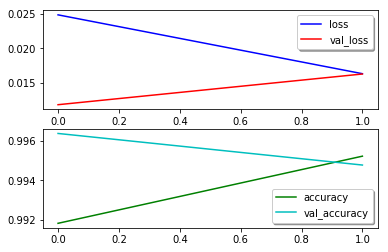

In [36]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="loss")
ax[0].plot(history.history['val_loss'], color='r', label="val_loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='g', label="accuracy")
ax[1].plot(history.history['val_acc'], color='c',label="val_accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
extract_feature_model = model.predict(fetch_feature_test)
extract_feature_model = extract_feature_model.clip(min=0.005, max=0.995)
extract_feature_model = extract_feature_model.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': extract_feature_model})
submission.to_csv('fetch_extract_feature_submission.csv',index=False)


## 五、总结

- 使用finetune和特征融合，的确比单一模型的预测效果更优。通过实验，特征融合的效果要比finetune的效果更好。
- 进一步提高预测结果的方法，大致有两种：一是使用更加优的模型（或预训练模型），或者使用更多的模型特征融合；二是扩大数据集，或者使用图片增强的方法等。

- 由于猫狗大战比赛的评判标准是对数损失（交叉熵），公式： 
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$

- 因为 $log1=0$, $log0=−∞$, $log⁡0.995=−0.002,log⁡0.005=−2.3$, 0.995和1的预测正确结果相差无几，但预测错误时，0和0.005的差距比较大
- 所以将每个预测值限制到了 [0.005, 0.995] 区间内,能够有效的降低对数损失值。


**以下是各模型训练的结果**：  

Extract Feature = InceptionV3 + Xception + inceptionResNetV2

|      model|    epochs |       LogLoss|  ranking|
| ----------- | ----------- | -------------| ----------|
|InceptionV3     |    10 |     0.07607|   >220|
|Xception       |    10 |     0.05390|   90|
|inceptionResNetV2 |    10 |     0.06508|   <150|
|Xception(finetune)|     8|     0.04205|   <20|
|Extract Feature  |     10|     0.03826|   <12|

参考资料：

- [ResNet](https://arxiv.org/abs/1512.03385)
- [InceptionV3 ](https://arxiv.org/abs/1512.00567)
- [Xception](https://arxiv.org/abs/1610.02357)
- [logloss](https://www.kaggle.com/wiki/LogLoss)